In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm  # Import tqdm

# Step 1: Load the dataset and split it into training and validation sets
(ds_train, ds_validation), info = tfds.load('food101', split=['train', 'validation'], as_supervised=True, with_info=True, download=True)

# Step 2: Filter out images except for "pizza" and "tacos"
def filter_categories(image, label):
    # Keep only images with "pizza" or "tacos" labels (labels 76 and 96 in Food101 dataset)
    return label == 76 or label == 96

# Apply the filter to training and validation sets
ds_train_filtered = ds_train.filter(filter_categories)
ds_validation_filtered = ds_validation.filter(filter_categories)

In [4]:
# Workaround to count the number of elements in the filtered datasets with a progress bar
num_train_filtered = sum(1 for _ in tqdm(ds_train_filtered, desc="Counting train set"))
num_validation_filtered = sum(1 for _ in tqdm(ds_validation_filtered, desc="Counting validation set"))

Counting train set: 1500it [00:45, 33.30it/s]
Counting validation set: 500it [00:14, 35.53it/s]


In [5]:
print("Number of 'pizza' and 'tacos' images in the filtered train set:", num_train_filtered)
print("Number of 'pizza' and 'tacos' images in the filtered validation set:", num_validation_filtered)

Number of 'pizza' and 'tacos' images in the filtered train set: 1500
Number of 'pizza' and 'tacos' images in the filtered validation set: 500


In [6]:
# Access the Food101 dataset builder
builder = tfds.builder('food101')

# Print the data directory
print("Dataset data directory:", builder.data_dir)

Dataset data directory: C:\Users\eacro\tensorflow_datasets\food101\2.0.0


In [14]:
# Define model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 classes: 'pizza' and 'tacos'
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set batch size and number of epochs
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [8]:
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    
    # Map original labels (76 and 96) to correct labels (0 and 1)
    label = tf.cast(label, tf.int32)  # Ensure label is int32
    label = tf.where(label == 76, 0, label)
    label = tf.where(label == 96, 1, label)
    
    return image, label
# Apply preprocessing to datasets
ds_train = ds_train_filtered.map(preprocess).shuffle(buffer_size=1000).batch(BATCH_SIZE)
ds_validation = ds_validation_filtered.map(preprocess).batch(BATCH_SIZE)

In [9]:
# Train the model
history = model.fit(ds_train, epochs=NUM_EPOCHS, validation_data=ds_validation)

Epoch 1/10
47/47 [==============================] - 101s 1s/step - loss: 0.7489 - accuracy: 0.5627 - val_loss: 0.6255 - val_accuracy: 0.6700
Epoch 2/10
47/47 [==============================] - 95s 1s/step - loss: 0.5994 - accuracy: 0.6920 - val_loss: 0.5284 - val_accuracy: 0.7420
Epoch 3/10
47/47 [==============================] - 83s 1s/step - loss: 0.5663 - accuracy: 0.6933 - val_loss: 0.5027 - val_accuracy: 0.7640
Epoch 4/10
47/47 [==============================] - 80s 1s/step - loss: 0.5572 - accuracy: 0.7113 - val_loss: 0.5543 - val_accuracy: 0.7020
Epoch 5/10
47/47 [==============================] - 83s 1s/step - loss: 0.5165 - accuracy: 0.7493 - val_loss: 0.4825 - val_accuracy: 0.7800
Epoch 6/10
47/47 [==============================] - 81s 1s/step - loss: 0.4791 - accuracy: 0.7707 - val_loss: 0.4543 - val_accuracy: 0.7860
Epoch 7/10
47/47 [==============================] - 83s 1s/step - loss: 0.4213 - accuracy: 0.8060 - val_loss: 0.5321 - val_accuracy: 0.7720
Epoch 8/10
47/47 [=

In [10]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(ds_validation)
print("Validation accuracy:", validation_accuracy)

16/16 [==============================] - 6s 397ms/step - loss: 0.4403 - accuracy: 0.7960
Validation accuracy: 0.7960000038146973


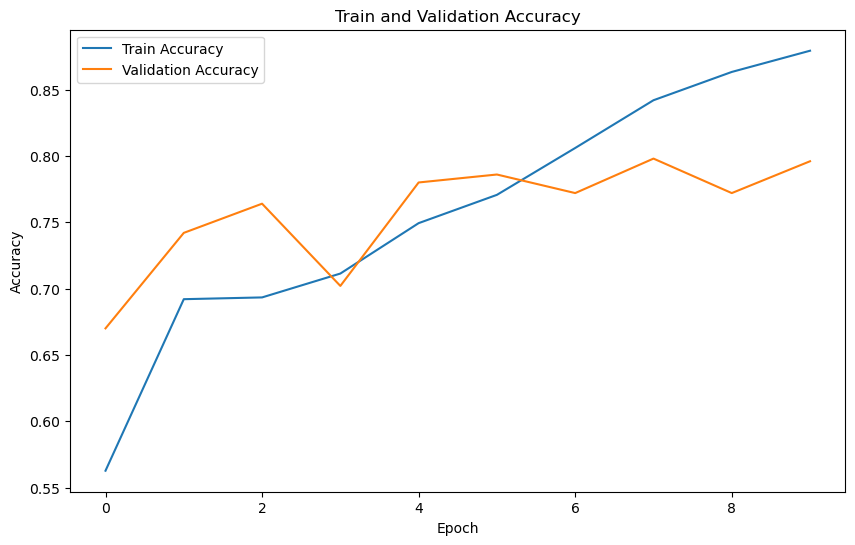

In [17]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# After training your model
model.save('model/food_model.keras')

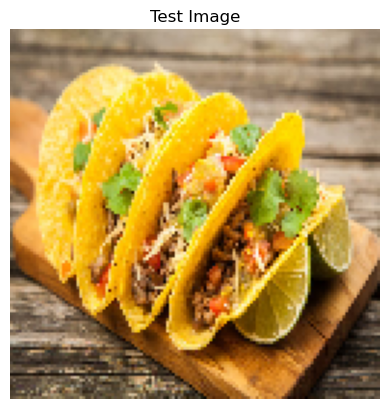

1/1 [==============================] - 0s 60ms/step
Looks like tacos!


In [18]:
loaded_model = load_model('model/food_model.keras')

# Load and preprocess the test image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

test_image_path = 'test_image/test.jpg'  # Replace 'path_to_test_image' with the path to your test image
preprocessed_image = preprocess_image(test_image_path)

# Display the preprocessed image
plt.imshow(preprocessed_image[0])
plt.title("Test Image")
plt.axis('off')
plt.show()

# Make predictions using the loaded model
predictions = loaded_model.predict(preprocessed_image)

# Interpret the predictions
class_labels = ['pizza', 'tacos']
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]

print(f"Looks like {predicted_class}!")